# Figure 17a: colour plot of the probabilities of re-invasion conditioning on the probability distribution of entering the Wolbachia-only state space from each mixed state

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import importlib
import multiprocessing as mp
import pylab as plt
import time
import random
import matplotlib
from matplotlib.colors import ListedColormap

Importing the required scripts

In [3]:
import SSA_random_wolbachia_hholds as sim
import Hughes_model
import Prob_absorb_to_each
import Finding_dictionary_keys

F = Hughes_model.F_hughes
importlib.reload(sim)   
gillespie = sim.gillespie
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
find_keys = Finding_dictionary_keys.find_keys

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [5]:
K = 30           # reproductive carrying capacity
d1 = 12/100      # wild-type death rate
d2 = 12/100      # Wolbachia death rate
k = 0.3          # mosquito competition parameter
h = 0.19*100**k  # mosquito competition parameter
b1 = round(d1/F(10,h,k),2)  # wild-type per capita birth rate
phi = 9/10       # Wolbachia fitness
b2 = b1*phi      # Wolbachia per capita birth rate
v = 9/10         # probability of vertical transmission
u = 10/10        # ratio of unviable offspring produced by an infected male and uninfected female
max_pop = K      # max household size

# create a dictionary to store all parameter values
params_dict_old = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct dictionaries for full state space and transient states (mixed)

In [7]:
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
trans_dict = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(1,max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}
n_transient = len(trans_dict)       # number of mixed states

Find the probability distributions for entering the Wolbachia-only state space for each mixed state

In [8]:
# initialise array for probability distributions of entering the Wolbachia-only state space from each mixed state
wolb_enter_dist = np.zeros((n_transient,max_pop)) 

for l in range(max_pop):   # looping all the Wolbachia-only states
        absorb_state = np.array([0,l+1])    # current Wolbachia-only state
        # calculating the probability of entering the W-only state from each mixed state
        mixed_state_probs = np.transpose(prob_reach_absorb(state_dict,trans_dict,absorb_state,params_dict_old)[0])[0]
        wolb_enter_dist[:,l] = mixed_state_probs   # storing the probability distributions in an array

[[3.03623019e-01 1.05626436e-01 5.33168977e-02 ... 1.06419588e-08
  4.53576370e-09 0.00000000e+00]
 [1.44655648e-01 2.69840747e-01 1.28673949e-01 ... 2.15872875e-08
  9.20082824e-09 0.00000000e+00]
 [8.50178592e-02 1.51360308e-01 2.46298621e-01 ... 3.51411967e-08
  1.49777093e-08 0.00000000e+00]
 ...
 [5.34041101e-03 5.80482072e-03 5.61382864e-03 ... 6.67299401e-09
  2.84413092e-09 0.00000000e+00]
 [1.04130095e-02 1.14775097e-02 1.12268027e-02 ... 1.42378174e-08
  6.06837300e-09 0.00000000e+00]
 [5.16239730e-03 5.61132670e-03 5.42670102e-03 ... 6.45056087e-09
  2.74932656e-09 0.00000000e+00]]


Running many Gillespie simulations to calculate the probabilities of re-invasion under each initial distribution of the Wolbachia-only states. *Note* this code chunk takes several hours to run.

In [10]:
prob_revert_vec_Dye = np.zeros(n_transient)

tic = time.time()
for init_state in range(n_transient):
    # store parameters in dictionary
    params_dict = {'m0': m0,
                  #'w0': w0,
                  'm_free0': m_free0,
                  'w_free0': w_free0,
                  'rho': rho,                 
                  'tau': tau,                  
                  'b': b,
                  'K': K,
                  'd': d,
                  'delta': delta,
                  'v': v,
                  'phi': phi,
                  'u': u,
                  'H': H,
                  't_start': t_start,
                  't_end': t_end, 
                  'time_points': time_points,
                  'uvec': wolb_enter_dist[init_state,:],
                  'h': h,
                  'k': k}
    tic = time.time()
    pool = mp.Pool(mp.cpu_count())
    results = pool.map(gillespie, [params_dict for i in range(chains)])
    pool.close()
    toc = time.time()
    print('run time:',toc-tic)
    
    revert_count = 0        
    for i in range(chains):
        revert_count += results[i][2]
    prob_revert_vec_Dye[init_state] = revert_count/chains
toc = time.time()
print('run time:',toc-tic)

run time: 106.5965588092804
run time: 129.99057841300964
run time: 143.05163192749023
run time: 155.8147292137146
run time: 161.45749974250793
run time: 172.20063018798828
run time: 187.6217155456543
run time: 184.83210277557373
run time: 191.32565116882324
run time: 196.15089988708496
run time: 196.903653383255
run time: 199.67973256111145
run time: 203.85387349128723
run time: 205.8773729801178
run time: 205.9519534111023
run time: 206.6406605243683
run time: 206.09483766555786
run time: 215.72849369049072
run time: 216.80891513824463
run time: 211.21353888511658
run time: 210.43834829330444
run time: 210.3616578578949
run time: 219.3722848892212
run time: 222.782541513443
run time: 225.71751618385315
run time: 233.24662280082703
run time: 246.04747223854065
run time: 241.1179838180542
run time: 238.08140802383423
run time: 133.28607535362244
run time: 133.68276643753052
run time: 154.4837794303894
run time: 174.12868928909302
run time: 178.3356420993805
run time: 190.02260947227478


Save the invasion probabilities so don't have to re-run.

In [11]:
np.save('prob_revert_vec_Dye.npy', prob_revert_vec_Dye)

Reload invasion probabilities

In [9]:
prob_revert_vec = np.load('prob_revert_vec_Dye.npy')

Put invasion probabilities into an array in the correct format to produce the colour plot.

In [14]:
revert_color_vec = np.zeros((max_pop,max_pop))  # initialise colour plot array
    
for k in range(n_transient):      # looping over the mixed states
    indx1, indx2 = trans_dict[k]  # extracting the correct indices 
    # recording the re-invasion probability at the correct indices
    revert_color_vec[indx1-1,indx2-1] = prob_revert_vec_Dye[k]

Plotting the figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


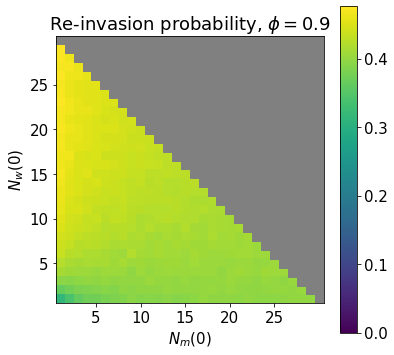

In [15]:
plt.figure(figsize=(6, 6))  # figure size
matplotlib.rcParams.update({'font.size': 15})  # font size

Z = np.transpose(revert_color_vec) # swapping entries to be the correct way round for the colour plot
my_cmap = plt.cm.viridis  # colour scheme
num_levels = 1000000
my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels))) # choosing how fine the colour grid is
plt.imshow(Z, cmap=my_cmap, interpolation='nearest', origin='lower')  # producing the colour plot

plt.xlabel('$N_m(0)$')   # x labels
plt.ylabel('$N_w(0)$')   # y labels
plt.yticks([4,9,14,19,24],['5','10','15','20','25'])    # y ticks
plt.xticks([4,9,14,19,24],['5','10','15','20','25'])    # x ticks

# colouring in the squares outside of the household size bounds grey 
for i in range(max_pop):    # looping over the y axis
    highlight_row, highlight_col = max_pop-i-1,i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray')
    current_axes = plt.gca()    # keeping track of axes
    current_axes.add_patch(rect)  # adds grey rectangle

plt.colorbar()   # adds colour bar
plt.title('Re-invasion probability, $\phi=${}'.format(phi))   # title
plt.savefig('prob_reinvasion_Dye.pdf', bbox_inches='tight')   # saves figure

Investigating the range of re-invasion probabilities

In [14]:
print('The mean re-invasion probability is', np.mean(prob_revert_vec))

The mean re-invasion probability is 0.4238022988505747


In [12]:
print('The smallest re-invasion probability is', np.min(prob_revert_vec), 'from state', trans_dict[np.argmin(prob_revert_vec)])

The smallest re-invasion probability is 0.3158 from state [1 1]


In [13]:
print('The largest re-invasion probability is', np.max(prob_revert_vec), 'from state', trans_dict[np.argmax(prob_revert_vec)])

The largest re-invasion probability is 0.47632 from state [ 1 29]
